In [ ]:
import numpy as np
import pandas as pd

# Load dataset
df = pd.read_csv("/content/haptic_feedback_liver.csv")

# Constants for KV & HC Models
K_KV, B_KV = 1000, 50   # KV Model coefficients
K_HC, B_HC = 1200, 60   # HC Model coefficients
n = 1.5  # Non-linearity parameter for HC

# Compute penetration depth (Hookean deformation)
df['penetration_depth'] = df['force_ground_truth'] / df['stiffness']

# Compute velocity (rate of deformation)
df['velocity'] = df['penetration_depth'] / df['interaction_duration']

# Compute Kelvin-Voigt Force
df['force_kv'] = (K_KV * df['penetration_depth']) + (B_KV * df['velocity'])

# Compute Hertz-Crossley Force
df['force_hc'] = (K_HC * df['penetration_depth'] ** n) + (B_HC * df['penetration_depth'] ** n * df['velocity'])

# Save transformed dataset
df.to_csv("transformed_haptic_feedback.csv", index=False)
print("Dataset transformed and saved as 'transformed_haptic_feedback.csv'")

Dataset transformed and saved as 'transformed_haptic_feedback.csv'


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Load transformed dataset
df = pd.read_csv("transformed_haptic_feedback.csv")

# Features & target variables for KV and HC
features_kv = ['force_kv', 'penetration_depth', 'velocity', 'elasticity', 'stiffness', 'viscosity']
features_hc = ['force_hc', 'penetration_depth', 'velocity', 'elasticity', 'stiffness', 'viscosity']
target = 'force_ground_truth'

# Train-test split (80% train, 20% test)
X_kv_train, X_kv_test, y_train, y_test = train_test_split(df[features_kv], df[target], test_size=0.2, random_state=42)
X_hc_train, X_hc_test, _, _ = train_test_split(df[features_hc], df[target], test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_kv_train = scaler.fit_transform(X_kv_train)
X_kv_test = scaler.transform(X_kv_test)
X_hc_train = scaler.fit_transform(X_hc_train)
X_hc_test = scaler.transform(X_hc_test)

# Define ML models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=200, learning_rate=0.05, random_state=42),
    "Neural Network": MLPRegressor(hidden_layer_sizes=(100, 50), activation='relu', solver='adam', max_iter=500)
}

# Train & Evaluate models for both force models
results = []

def evaluate_models(X_train, X_test, y_train, y_test, model_type):
    for name, model in models.items():
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)

        # Compute evaluation metrics
        r2 = r2_score(y_test, predictions)
        mse = mean_squared_error(y_test, predictions)
        mae = mean_absolute_error(y_test, predictions)

        results.append([model_type, name, r2, mse, mae])

# Evaluate KV-based models
evaluate_models(X_kv_train, X_kv_test, y_train, y_test, "Kelvin-Voigt")

# Evaluate HC-based models
evaluate_models(X_hc_train, X_hc_test, y_train, y_test, "Hertz-Crossley")

# Display results
results_df = pd.DataFrame(results, columns=["Force Model", "ML Model", "R² Score", "MSE", "MAE"])
print(results_df)

# Save results
results_df.to_csv("ml_force_model_comparison.csv", index=False)

      Force Model           ML Model  R² Score           MSE           MAE
0    Kelvin-Voigt  Linear Regression  1.000000  3.890152e-30  1.650855e-15
1    Kelvin-Voigt      Random Forest  1.000000  5.457373e-10  1.703465e-05
2    Kelvin-Voigt  Gradient Boosting  0.999987  2.495477e-05  3.764490e-03
3    Kelvin-Voigt     Neural Network  0.999993  1.435877e-05  3.235479e-03
4  Hertz-Crossley  Linear Regression  1.000000  1.272595e-29  3.051684e-15
5  Hertz-Crossley      Random Forest  1.000000  6.821662e-10  1.844051e-05
6  Hertz-Crossley  Gradient Boosting  0.999987  2.495580e-05  3.764518e-03
7  Hertz-Crossley     Neural Network  0.999999  1.360140e-06  8.939310e-04


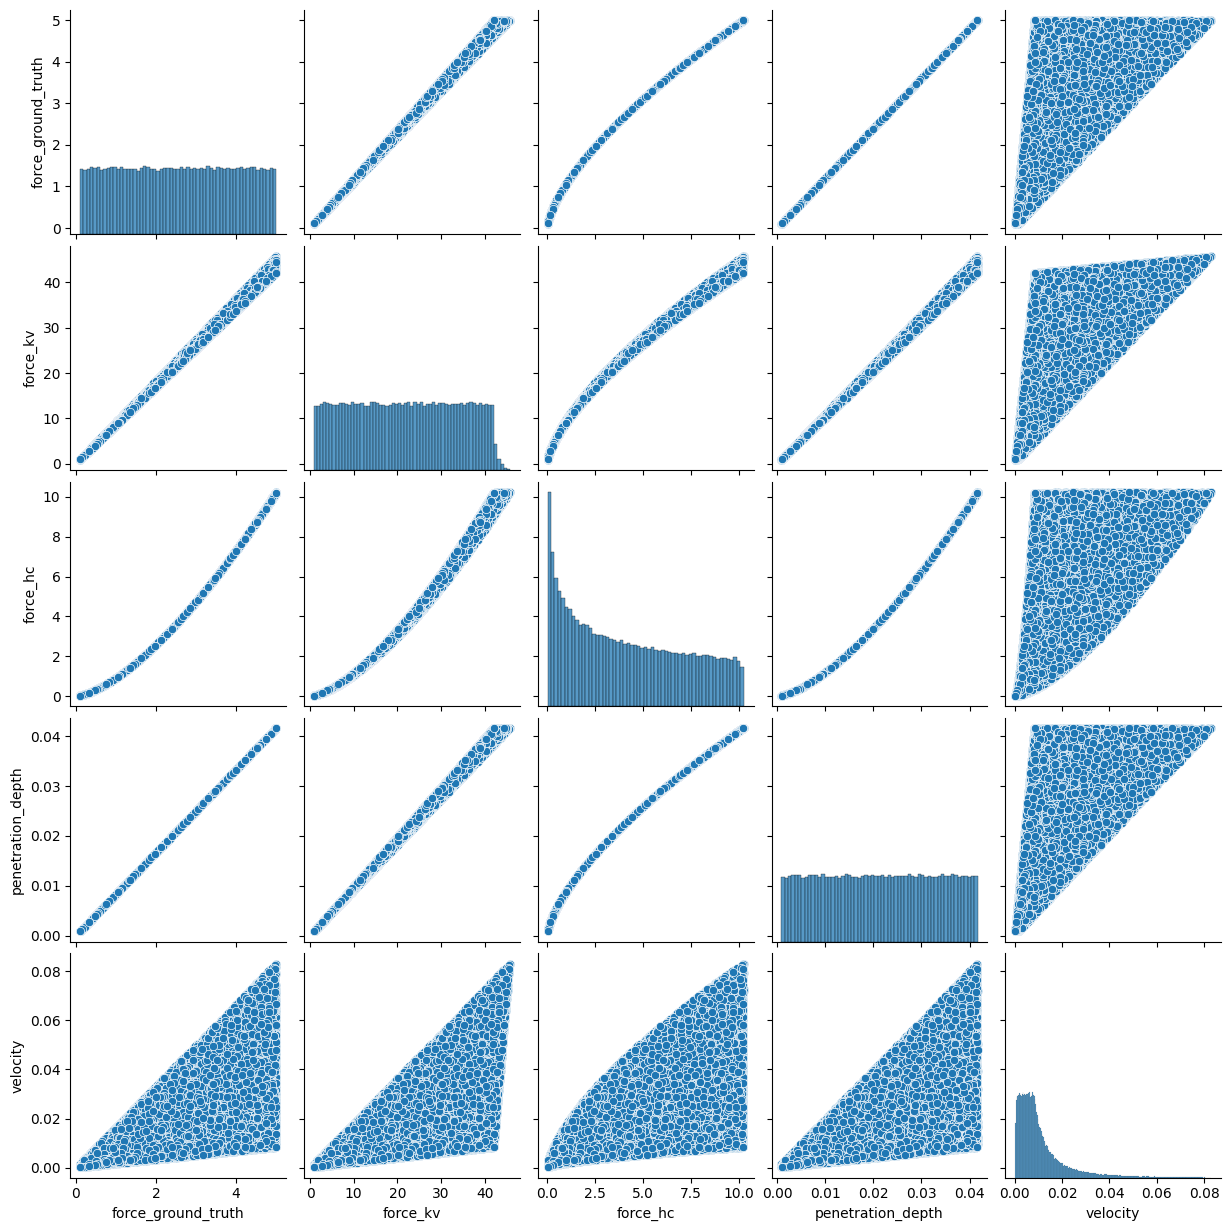

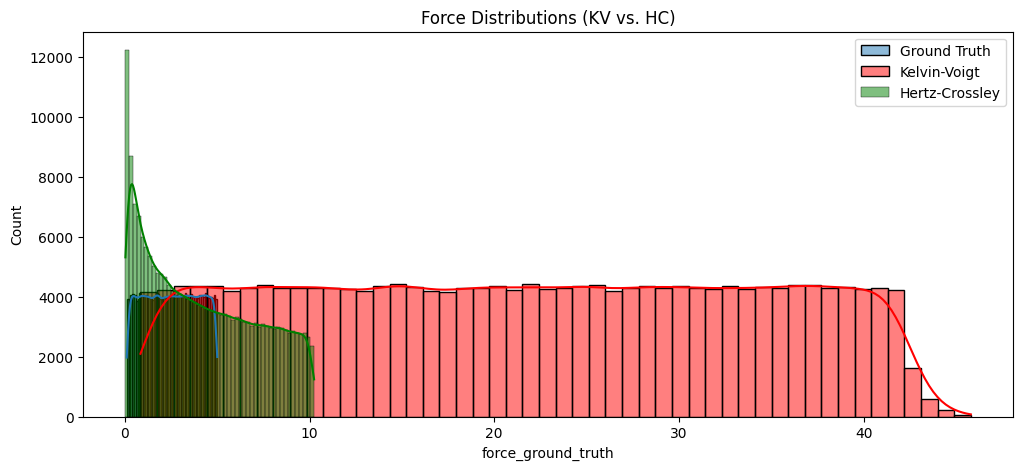

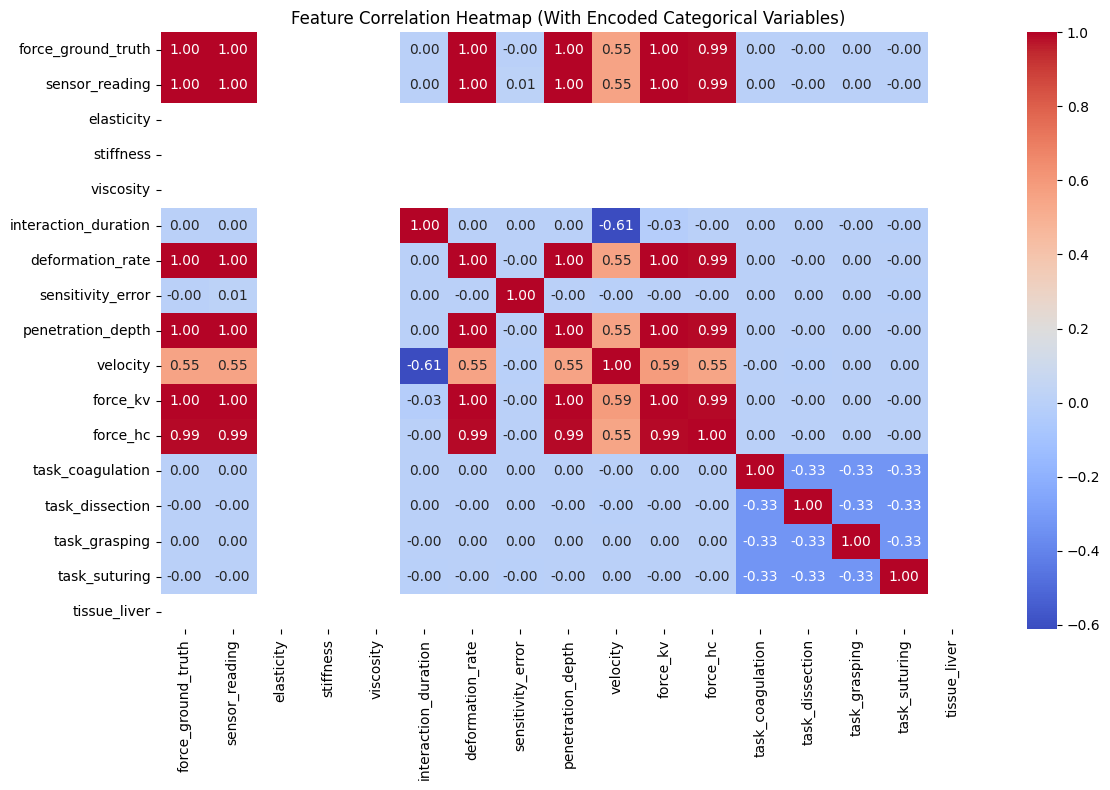

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("transformed_haptic_feedback.csv")

# Pairplot to see relationships
sns.pairplot(df[['force_ground_truth', 'force_kv', 'force_hc', 'penetration_depth', 'velocity']])
plt.show()

# Distribution of forces
plt.figure(figsize=(12, 5))
sns.histplot(df['force_ground_truth'], bins=50, kde=True, label='Ground Truth')
sns.histplot(df['force_kv'], bins=50, kde=True, label='Kelvin-Voigt', color='red', alpha=0.5)
sns.histplot(df['force_hc'], bins=50, kde=True, label='Hertz-Crossley', color='green', alpha=0.5)
plt.legend()
plt.title("Force Distributions (KV vs. HC)")
plt.show()

# Correlation heatmap with encoded categorical variables
plt.figure(figsize=(12, 8))
categorical_columns = ['task', 'tissue']
df_encoded = pd.get_dummies(df, columns=categorical_columns)

# Create correlation heatmap
sns.heatmap(df_encoded.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap (With Encoded Categorical Variables)")
plt.tight_layout()
plt.show()

In [ ]:
import sys
import pickle

# Calculate size of each model in the dictionary
model_sizes = {}
for model_name, model in models.items():
    model_size_bytes = sys.getsizeof(pickle.dumps(model))
    model_sizes[model_name] = model_size_bytes / (1024 * 1024)  # Convert to MB

# Display the sizes in MB
model_sizes



{'Linear Regression': 0.000507354736328125,
 'Random Forest': 1387.5302429199219,
 'Gradient Boosting': 0.25563812255859375,
 'Neural Network': 0.18181133270263672}

Saved Linear Regression as linear_regression_model.pkl
Saved Random Forest as random_forest_model.pkl
Saved Gradient Boosting as gradient_boosting_model.pkl
Saved Neural Network as neural_network_model.pkl
Compressed Random Forest model saved as random_forest_model.tar.gz


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>